# Preprocessing
1. Read the dataset including N-clip ictal and M-clip interictal samples.
2. Parse the header and content. Label each timestep as 0 or 1.
3. Slipt the content into 5-fold so that train and test sets are 80% and 20%, respectively.
4. Oversample minority class in train sets
5. Standardize the train sets. Get the common mean and standard deviation for test sets. 
6. Create one train and test set by concantenating and then suffling ictal and interictal set.
7. Store 5 datasets in 5 files 

In [6]:
import numpy as np
import collections
import os
import argparse
import datetime as dt
import random
import scipy.io as spio
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

In [2]:
class subject:
    def __init__(self, ictal_sample, interictal_sample, n_timestep, n_feature): 
        self.ictal_sample = ictal_sample
        self.interictal_sample = interictal_sample
        self.sfreq = n_timestep
        self.nfeat = n_feature

In [3]:
# =================================================
# Low pass filter
# =================================================
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Oversampling ictal

In [11]:
# ============================================
# 1) Parse all ictal and interictal files
# 2) Oversample ictal
# 3) Store their contents into 2 seperate arrays 
# ============================================
def xt_load_rawdata(subject, filter_en, resample_en, dir_in): 
    mark = ['ictal', 'interictal']
    
    # -------------------------------------------------------
    # Step 1, 2
    # -------------------------------------------------------
    # Obtain frequence bands
    if filter_en == 1:
        n_band = 5
    else:
        n_band = 1
     
    # Resample patient 5000 Hz to 500 Hz
    if resample_en == 1:
        s_freq = int(subject.sfreq / 10)
    else:
        s_freq = subject.sfreq
    
    Xic = np.zeros((subject.ictal_sample, s_freq, subject.nfeat * n_band))
    Xit = np.zeros((subject.interictal_sample, s_freq, subject.nfeat * n_band))
    yic = np.zeros((subject.ictal_sample, s_freq, n_band))
    yit = np.zeros((subject.interictal_sample, s_freq, n_band))
    
    for i in range (0, 2):
        #
        if mark[i] == 'ictal':
            end_fileID = subject.ictal_sample + 1
            data_path_in = dir_in + '_ictal_segment_'
        else:
            end_fileID = subject.interictal_sample + 1
            data_path_in = dir_in + '_interictal_segment_'
         
        #
        for file_id in range (1, end_fileID):
            file_in = data_path_in + str(file_id) + '.mat' 

            mat = spio.loadmat(file_in)

            # Number of channels
            n_channel = len(mat['channels'][0][0])
            # Sampling frequency
            s_freq = mat['freq']
            # Number of samples
            n_sample = int(np.round(s_freq))

            # ----------------------------------
            if filter_en == 1:
                # Band-pass filter
                order = 6
                lowcut_freq = [1, 4, 8, 12, 30]
                highcut_freq = [4, 8, 12, 30, 64]
                X = np.zeros((n_channel * n_band, subject.sfreq))
                for j in range (0, n_channel):
                    kk = j*5
                    for k in range (0, 5):
                        X[kk + k] = butter_bandpass_filter(mat['data'][j], lowcut_freq[k], highcut_freq[k], \
                                                           subject.sfreq, order)
                X = X.T
                
            elif resample_en == 1:
                # Resample 5000 Hz to 500 Hz
                X = np.zeros((n_channel, 500))
                if n_sample == 5000:
                    for j in range (0, n_channel):
                        kk = 0
                        for k in range (0, subject.sfreq, 10):
                            X[j][kk] = mat['data'][j][k]
                            #X[j][kk] = np.average(mat['data'][j][k:k+10]) 
                            kk = kk+1
                    X = X.T
                    n_sample = 500
            else:
                X = mat['data'].T
                
            # ----------------------------------
            # Latency only in ICTAL
            if mark[i] == 'ictal':
                # Latency
                latency = int(mat['latency'])

                #print(file_id, ': Channel numbers =', n_channel, 'Sampling frequency =', s_freq, \
                #      'Resampling frequency =', n_sample, 'Latency =', latency);
                y = np.ones((n_sample, 1))

            # No latency in INTERICTAL
            else:
                #print(file_id, ': Channel numbers =', n_channel, 'Sampling frequency =', s_freq, \
                #      'Resampling frequency =', n_sample);
                y = np.zeros((n_sample, 1))
            
            # ---------------------------------- 
            if mark[i] == 'ictal':
                Xic[file_id-1] = X
                yic[file_id-1] = y
            else:
                Xit[file_id-1] = X
                yit[file_id-1] = y 
                
    #Xic_tmp = np.asarray(Xic )
    #dim = Xic_tmp.shape
    #Xic_tmp = Xic_tmp.reshape((dim[0] * dim[1]), dim[2])
    #np.savetxt('./Results_copy1/tmpXic', Xic_tmp, fmt = '%.4f')        
    #np.savetxt('./Results_copy1/tmpXit', Xic, fmt = '%.4f') 

    if resample_en == 1:
        subject.sfreq = 500
    return Xic, yic, Xit, yit


# ============================================
# 1) Use K-fold function to slipt data 5 times
# 2) Oversample ictal
# 4) Concantenate ictal and interictal
# 5) Standardize each fold, calculate average mean and standard deviation for all test sets
# 6) Suffle and store 5 arrays into 5 files
# ============================================
def xt_prep_dataset(subject, dir_ou, k, Xic, yic, Xit, yit, std, filter_en, shuffle_train_en):    # std = 1: standardize
    
    # -------------------------------------------------------
    # Step 1 
    # -------------------------------------------------------
    if filter_en == 1:
        n_band = 5
    else:
        n_band = 1
        
    kf = KFold(n_splits=k) # Define the split - into 5 folds   
    
    Xic_train = []
    Xit_train = []
    yic_train = []
    yit_train = []
    
    Xic_test  = []
    Xit_test  = []
    yic_test  = []
    yit_test  = []
      
    for train_index, test_index in kf.split(Xic): 
        Xic_train.append(Xic[train_index])
        yic_train.append(yic[train_index])   
        Xic_test.append(Xic[test_index])
        yic_test.append(yic[test_index])
        
    for train_index, test_index in kf.split(Xit):
        Xit_train.append(Xit[train_index])
        yit_train.append(yit[train_index])
        Xit_test.append(Xit[test_index])
        yit_test.append(yit[test_index])                       
    
    # -------------------------------------------------------
    # Step 2
    # -------------------------------------------------------
    # How difference interictal vs ictal
    n_ict_int = int(np.round(subject.interictal_sample / subject.ictal_sample))
    
    # Shift value 
    #n_shift = int(subject.sfreq / (subject.interictal_sample / subject.ictal_sample))
    n_shift = int(subject.sfreq / n_ict_int)
    
    print('--- --- Debug: n_ict_int, n_shift =', n_ict_int, n_shift)
    Xic_train_gen = []
    yic_train_gen = []
    for i in range (0, k):
        # Reshape
        Xic_train_tmp = np.asarray(Xic_train[i])
        dim = Xic_train_tmp.shape
        Xic_train_tmp = Xic_train_tmp.reshape((dim[0] * dim[1]), dim[2])
        global_start_id = n_shift
        
        # Add new samples to Xic_train
        tmp_XX = []
        tmp_YY = []
        for j in range (0, n_ict_int): 
            start_id = global_start_id
            end_id = start_id + (dim[0]-1) * subject.sfreq
            #print(dim, start_id, end_id, subject.sfreq, Xic_train_tmp[start_id:end_id].shape)     
            tmp_X = Xic_train_tmp[start_id:end_id,:].reshape((dim[0]-1, subject.sfreq, dim[2]))
            tmp_Y = np.ones((dim[0]-1, subject.sfreq, n_band))
            if j == 0:
                tmp_XX = tmp_X
                tmp_YY = tmp_Y
            else: 
                tmp_XX = np.concatenate((tmp_XX, tmp_X), axis=0)
                tmp_YY = np.concatenate((tmp_YY, tmp_Y), axis=0)
                
            global_start_id = global_start_id + n_shift
        
        #print(tmp_XX.shape, tmp_YY.shape) 
        Xic_train_gen.append(tmp_XX)
        yic_train_gen.append(tmp_YY)
 
    # -------------------------------------------------------
    # Step 3, 4, 5
    # -------------------------------------------------------
    # Standardize train and test datasets
    X_mean = []
    X_std = [] 
    for i in range (0, k): 
        X_train = np.concatenate((Xic_train[i], Xic_train_gen[i], Xit_train[i]), axis = 0)
        y_train = np.concatenate((yic_train[i], yic_train_gen[i], yit_train[i]), axis = 0)
        X_test = np.concatenate((Xic_test[i], Xit_test[i]), axis = 0)
        y_test = np.concatenate((yic_test[i], yit_test[i]), axis = 0)

        X_train = np.asarray(X_train)
        y_train = np.asarray(y_train)
        X_test = np.asarray(X_test)
        y_test = np.asarray(y_test)
        
        dim_Xtr = X_train.shape
        dim_ytr = y_train.shape
        dim_Xte = X_test.shape 
        dim_yte = y_test.shape
        
        #print('------ Debug =', dim_Xtr, dim_ytr, dim_Xte, dim_yte)         

        # ---------------------------
        if std == 1:
            # 3D to 2D -> Standardize -> 2D to 3D
            # 3D to 2D
            X_train = X_train.reshape((dim_Xtr[0]*dim_Xtr[1]), dim_Xtr[2])
            y_train = y_train.reshape((dim_ytr[0]*dim_ytr[1]), dim_ytr[2])
            X_test = X_test.reshape((dim_Xte[0]*dim_Xte[1]), dim_Xte[2])
            y_test = y_test.reshape((dim_yte[0]*dim_yte[1]), dim_yte[2])

            # Standardize
            scaler = preprocessing.StandardScaler().fit(X_train) 
            X_mean.append(scaler.mean_)
            X_std.append(scaler.scale_)

            X_train_scaled = scaler.transform(X_train)
            X_test_scaled = scaler.transform(X_test)
 
            # 2D to 3D
            X_train = X_train_scaled.reshape(dim_Xtr[0], dim_Xtr[1], dim_Xtr[2])
            y_train = y_train.reshape(dim_ytr[0], dim_ytr[1], dim_ytr[2])
            X_test = X_test_scaled.reshape(dim_Xte[0], dim_Xte[1], dim_Xte[2])
            y_test = y_test.reshape(dim_yte[0], dim_yte[1], dim_yte[2])

        # --------------------------------
        # Suffle -> 3D to 2D -> Store to file
        # Shuffle
        if shuffle_train_en == 1:
            X_train, y_train = shuffle(X_train, y_train, random_state=29)
            #X_test, y_test = shuffle(X_test, y_test, random_state=2)
            print('------ Shuffle, Debug =', i, X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        else:
            print('------ No shuffle, Debug =', i, X_train.shape, y_train.shape, X_test.shape, y_test.shape)                 

        # 3D to 2D 
        X_train  = X_train.reshape((dim_Xtr[0]*dim_Xtr[1]), dim_Xtr[2])
        y_train = y_train.reshape((dim_ytr[0]*dim_ytr[1]), dim_ytr[2])
        X_test  = X_test.reshape((dim_Xte[0]*dim_Xte[1]), dim_Xte[2])
        y_test = y_test.reshape((dim_yte[0]*dim_yte[1]), dim_yte[2])

        # Store to file
        file_ou = dir_ou + 'train_' + str(i)
        np.savetxt(file_ou, np.hstack((X_train, y_train)), fmt = '%.4f')   
        file_ou = dir_ou + 'test_' + str(i)
        np.savetxt(file_ou, np.hstack((X_test, y_test)), fmt = '%.4f') 
 
    #print(X_mean, X_std) 

# =========================================================
# Test function
# =========================================================
# ------------------------------------------------
# User setting
norm_en = 1
filter_en = 0
shuffle_train_en = 1
test_subject_id = 'Patient_8' # Dog_1, ..., Patient_1, ...
                             
# ------------------------------------------------
if test_subject_id == 'Dog_1' or test_subject_id == 'Dog_2' or \
    test_subject_id == 'Dog_3' or test_subject_id == 'Dog_4' or \
     test_subject_id == 'Patient_1':
    resample_en = 0
else:
    resample_en = 1

if test_subject_id == 'Dog_1':                            
    test_subject = subject(178, 418, 400, 16)
elif test_subject_id == 'Dog_2': 
    test_subject = subject(172, 1148, 400, 16)
elif test_subject_id == 'Dog_3':
    test_subject = subject(480, 4760, 400, 16)
elif test_subject_id == 'Dog_4':
    test_subject = subject(257, 2790, 400, 16)
elif test_subject_id == 'Patient_1':
    test_subject = subject(70, 104, 500, 68)
elif test_subject_id == 'Patient_2':
    test_subject = subject(151, 2990, 5000, 16)
elif test_subject_id == 'Patient_3':
    test_subject = subject(327, 714, 5000, 55)
elif test_subject_id == 'Patient_4':
    test_subject = subject(20, 190, 5000, 72)    
elif test_subject_id == 'Patient_5':
    test_subject = subject(135, 2610, 5000, 64) 
elif test_subject_id == 'Patient_6':
    test_subject = subject(225, 2772, 5000, 30) 
elif test_subject_id == 'Patient_7':
    test_subject = subject(282, 3239, 5000, 36) 
elif test_subject_id == 'Patient_8':
    test_subject = subject(180, 1710, 5000, 16) 

 
dir_in = 'D:\\Romanlab\XT_DataSet\dataset2\\' + test_subject_id + '\\' + test_subject_id 
dir_ou = 'D:\\Romanlab\XT_DataSet\dataset2\\' + test_subject_id + 'OG\\'   

k = 5  # K-fold 
Xic, yic, Xit, yit = xt_load_rawdata(test_subject, filter_en, resample_en, dir_in)

xt_prep_dataset(test_subject, dir_ou, k, Xic, yic, Xit, yit, norm_en, filter_en, shuffle_train_en)  

--- --- Debug: n_ict_int, n_shift = 10 50
------ Shuffle, Debug = 0 (2942, 500, 16) (2942, 500, 1) (378, 500, 16) (378, 500, 1)
------ Shuffle, Debug = 1 (2942, 500, 16) (2942, 500, 1) (378, 500, 16) (378, 500, 1)
------ Shuffle, Debug = 2 (2942, 500, 16) (2942, 500, 1) (378, 500, 16) (378, 500, 1)
------ Shuffle, Debug = 3 (2942, 500, 16) (2942, 500, 1) (378, 500, 16) (378, 500, 1)
------ Shuffle, Debug = 4 (2942, 500, 16) (2942, 500, 1) (378, 500, 16) (378, 500, 1)


# Oversampling both ictal and interictal

--- --- Debug: n_overspl, n_shift = 3 133
--- --- Debug: n_ict_int, n_shift = 33 12
------ Debug = 0 (15862, 400, 16) (15862, 400, 1) (610, 400, 16) (610, 400, 1)
------ Debug = 1 (15862, 400, 16) (15862, 400, 1) (610, 400, 16) (610, 400, 1)
------ Debug = 2 (15896, 400, 16) (15896, 400, 1) (609, 400, 16) (609, 400, 1)
------ Debug = 3 (15896, 400, 16) (15896, 400, 1) (609, 400, 16) (609, 400, 1)
------ Debug = 4 (15896, 400, 16) (15896, 400, 1) (609, 400, 16) (609, 400, 1)


# Combine datasets

In [ ]:
# ============================================
# 1) Combine 4 train_i sets of Dog1, ..., Dog4 into 1 train_i
# 2) Combine 4 test_i sets of Dog1, ..., Dog4 into 1 test_i
# ============================================
def xt_concat_dataset(subject, n_subject, kfold, dir_in, dir_ou):

    dataset = ['train', 'test']

    for d in range (0, 2):
        #
        for j in range (0, kfold):
            #
            Xy = []
            for i in range (1, n_subject + 1):
                file_in = dir_in + 'Dog_' + str(i) + 'OB\\' + dataset[d] + '_' + str(j)
                print('Read file', file_in)
                Xy_tmp = np.loadtxt(file_in, delimiter=' ', usecols=(range(0, 17)))
                if i == 1:
                    Xy = Xy_tmp
                else:
                    Xy = np.concatenate((Xy, Xy_tmp), axis=0)

            file_ou = dir_ou + dataset[d] + '_' + str(j)
            print('Write file', file_ou)

            # 3D-to-2D
            Xy = np.asarray(Xy)
            dim = Xy.shape
            print('--- Shape of Xy', dim)
            np.savetxt(file_ou, Xy, delimiter=' ', fmt = '%.4f')
    
    
# =========================================================
# Test function
# =========================================================
dir_in = 'D:\\Romanlab\XT_DataSet\dataset2\\'
dir_ou = 'D:\\Romanlab\XT_DataSet\dataset2\Dog_OB\\'
kfold = 5
n_subject = 4

xt_concat_dataset(subject, n_subject, kfold, dir_in, dir_ou)    

# Check historam

Done


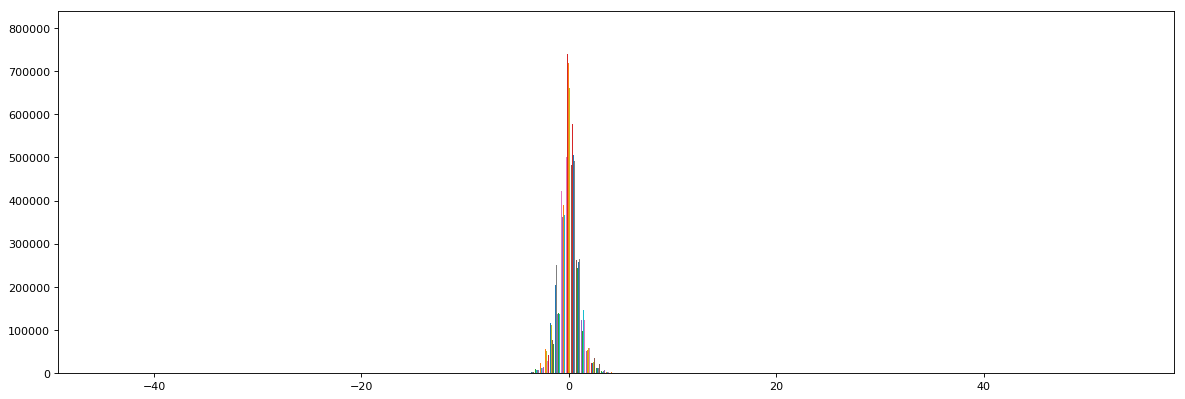

In [8]:
import numpy as np 
import matplotlib.pyplot as plt

#dir_in = 'D:\\Romanlab\\XT_DataSet\\dataset2\\Dog_1OU\\non_std\\'
dir_in = 'D:\\Romanlab\\XT_DataSet\\dataset2\\Patient_6OG\\'
fileID = 0 
n_timestep = 500 #400
n_channel= 30


file_train = dir_in + 'train_' + str(fileID) 

X_train = np.loadtxt(file_train, delimiter=' ', usecols=(range(0, n_channel))) 
#X_train = np.loadtxt(file_train, delimiter=' ', usecols=(10)) 

fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(X_train, bins=200) 
#plt.axis([-500, 500, 0, 1000000]) 
print('Done')

[-20, 20, 0, 800000]

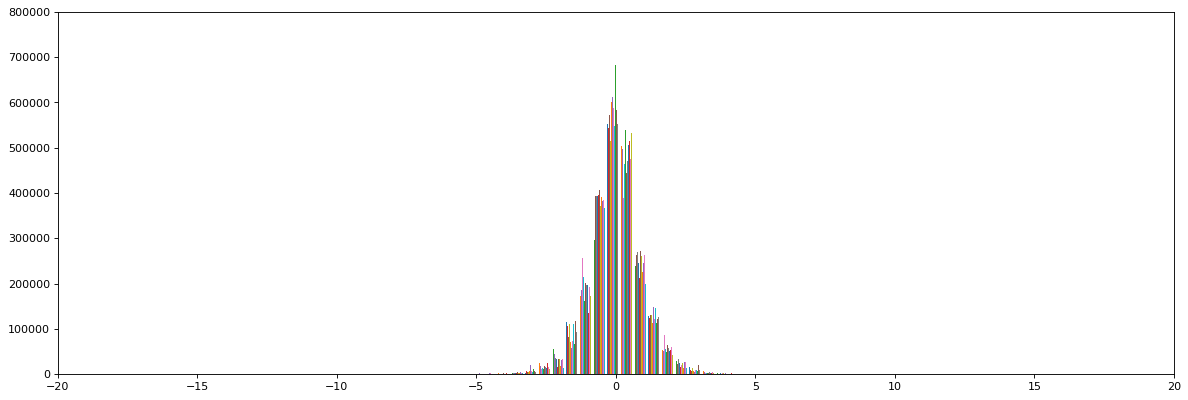

In [9]:
fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(X_train, bins=200) 
plt.axis([-20, 20, 0, 800000]) 

In [36]:
values, counts = np.unique(X_train, return_counts=True)
dim = values.shape 
tmp_values = values.reshape((dim[0], 1))
tmp_counts = counts.reshape((dim[0], 1)) 

tmp = np.hstack((tmp_values, tmp_counts ))

np.savetxt('./Results_copy1/histogram_norm_patient3', tmp, fmt = '%.4f')

(164346,)
(164346, 2)


# Check results

(815200,) (815200,)
=== Raw results === 
Diff = 23200
723200 5600 17600 68800 0.7962962962962963 0.9923161361141603
=== Filtered results === 
Diff = 23657
723058 5742 17915 68485 0.7926504629629629 0.9921212952799122


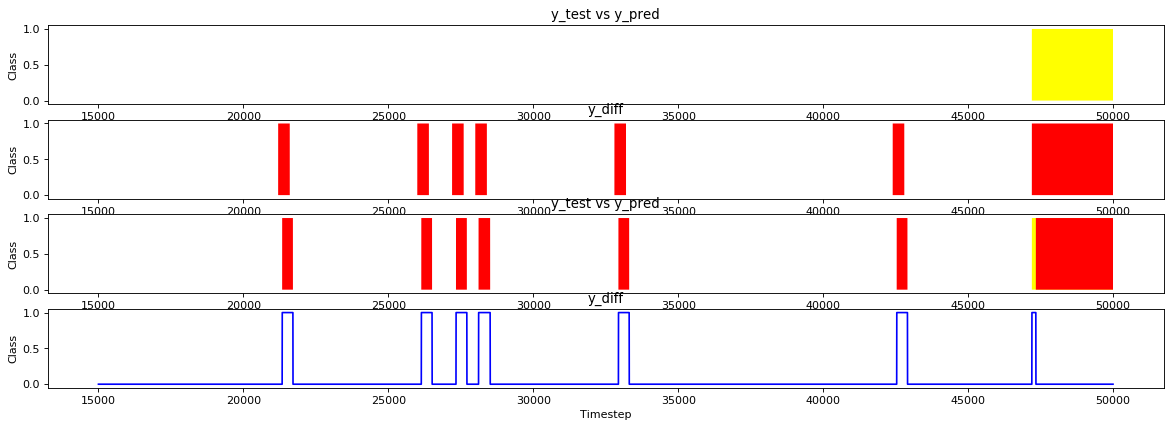

In [13]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score 


#file_in = '.\Results\\test-pred--date--id.k.bs.cw.hu1.hu2.hu3--2018.07.23.12.16--Dog_.0.64.1.32.0.0'
file_in = '.\Results\\20180723_Dog_CDLDAD_AUC\\test-pred--date--id.k.bs.cw.hu1.hu2.hu3--2018.07.23.05.55--Dog_.4.64.1.32.0.0'

#X_train = np.loadtxt(file_train, delimiter=' ', usecols=(range(9, 9))) 
[y_test, y_pred] = np.loadtxt(file_in, delimiter=' ') 
print(y_test.shape, y_pred.shape)

fig=plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')

start = 15000
end = 50000 #y_test.shape[0]
t = range (start, end)

# ==============================================
print('=== Raw results === ')

plt.subplot(4, 1, 1)
plt.fill_between(t, y_test[start:end], facecolor='yellow')
#plt.fill_between(t, y_pred[start:end], facecolor='red')
#plt.plot(t, y_test[start:end], color='r') 
#plt.plot(t, y_pred[start:end], color='b', linestyle=':')
plt.title('y_test vs y_pred')
plt.ylabel('Class')

plt.subplot(4, 1, 2)
y_diff = y_test != y_pred
#plt.plot(t, y_diff[start:end], color='b') 
plt.fill_between(t, y_pred[start:end], facecolor='red')
plt.title('y_diff')
plt.xlabel('Timestep')
plt.ylabel('Class')
print('Diff =', np.sum(y_diff))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sens = tp/(tp + fn)
spec = tn/(fp + tn)
print(tn, fp, fn, tp, sens, spec)

# ==============================================
print('=== Filtered results === ')
prev_value = 1
threshold = 80
y_pred_avg = np.ones(y_pred.shape[0])
p = 0.995   

for i in range (0, y_pred.shape[0] ):
    if i == 0:
        y_pred_avg[i] = y_pred[i]
    else:
        y_pred_avg[i] = y_pred[i] * (1 - p) + y_pred_avg[i-1] * p
        
y_pred_avg = np.round(y_pred_avg)        
        
plt.subplot(4, 1, 3)
plt.fill_between(t, y_test[start:end], facecolor='yellow')
plt.fill_between(t, y_pred_avg[start:end], facecolor='red')
#plt.plot(t, y_test[start:end], color='r') 
#plt.plot(t, y_pred[start:end], color='b', linestyle=':')
plt.title('y_test vs y_pred')
plt.ylabel('Class')

plt.subplot(4, 1, 4)
y_diff = y_test != y_pred_avg 
plt.plot(t, y_diff[start:end], color='b') 
plt.title('y_diff')
plt.xlabel('Timestep')
plt.ylabel('Class')
print('Diff =', np.sum(y_diff))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_avg).ravel()
sens = tp/(tp + fn)
spec = tn/(fp + tn)
print(tn, fp, fn, tp, sens, spec)